# Chapter 8: Voltage Stability | Control and Dynamics

#### A quick introduction voltage stability and control

Still a work in progress, if there is anything missing or you have some general feedback please contact Sjur Føyen at foyen.sjur@ntnu.no 

## Table of Contents

1. [Voltage stability in power systems](#voltage-stability-in-power-systems)
    - [Voltage in synchronous generators](#voltage-in-synchronous-generators)
    - [3. order linearized model and the voltage loop](#3-order-linearized-model-and-the-voltage-loop)
2. [Voltage control - AVR](#voltage-control---avr)
    - [Modeling an AVR](#modeling-an-avr)
    - [Tuning and analyzing the AVR](#tuning-and-analyzing-the-avr)
3. [Looking at the effect of AVR in tops](#looking-at-the-effect-of-avr-in-tops)

Relevant Material from TET4180 Power System Stability and Control:
1. Slides (TET4180 Power System Stability and Control | Generator controls - Excitation systems and voltage control)
2. Power System Dynamics, Machowski   (Ch. 8)


Code implemented by; Varg Førland. Date; 04.03.2025

Last update; 07.03.2025

GitHub Copilot used for assistance in coding.

In [6]:
# If you get a package error, uncomment and run the following lines:
# %pip install git+https://github.com/hallvar-h/tops
# %pip install control
# %pip install IPython.display
# %pip install numpy
# %pip install matplotlib
# %pip install ipywidgets

import matplotlib.pyplot as plt
import numpy as np
from notebook_utils import getPhasorsDictionary_SmallDist
from IPython.display import display, Math
import control as ctrl

# Control package documentation
"""https://python-control.readthedocs.io/en/0.10.0/"""

'https://python-control.readthedocs.io/en/0.10.0/'

# Voltage stability in power systems
This notebook will cover voltage stability in the power system, mainly focusing on the classical voltage stability and control of synchronous machines. However, the objectives and control concepts are often applicable in converter control as well.

## Voltage in synchronous generators
In synchronous generators the voltage is determined by the induced emf of the generator $\underline{E}$. This induced emf is determined by the excitation system of the windings in the generator. To control the voltage, we control this system through excitation control. This is generally referred to as an $AVR$. Lets take a closed look at the generator and components surrounding it in the figure below.

<div style="text-align: center;">
    <img src="Figures/7-8-Volt-freq-stab/genLoadEqvDiagram.png" alt="Power Plant, turbine and generator system." style="max-width: 65%;">
    <figcaption> Power Plant, turbine and generator system. </figcaption>
</div>

The excitation system has the following functions:
- Provide direct current to the machine field windings
- Control of voltage and reactive power flow
- Enhancement of system stability
- Protective functions ensure that the capability limits of
the synchronous machine, excitation system and other
equipment are not exceeded

Here we clearly see how the voltage of the generator and the excitation system is connected. The question then becomes how do we effectivly control this system? We control the system based on the on the control objectives, which can be summarized as 
- Maintain desired voltage / reactive power
- Voltage quality
- System stability
- Reactive power allocation/sharing

Note that maintaining desired voltage does not always mean a constant voltage. 

In order to effectivly design the regulators, we first need a model of the system.

## 3. order linearized model and the voltage loop
The system in the previous figure, is a complex system consisting of multiple mechanical and electrical components, each contributing with their own dynamics. When modeling and studying this system, simplifications must be made. One of the most effective simplifications done when modeling this system is looking at linearized models.

In our example we will look at the 3. order linearized model, consisting of three internal variables; speed/freq. $\Delta \omega$, voltage $\Delta E_f$ and rotor angle $\Delta \delta$. In this model, different parts of the power plant is modelled as linear transferfunctions in the laplace domain. By doing this we can describe the dynamics of the different components, and how they effect each other and the output. The 3. order model is a fairly simple model, and higher order models are often used to emulate the system more realistically (such as the 6. order model used in tops). The figure below shows the the 3. order linearized model. 
<div style="text-align: center;">
    <img src="Figures/7-8-Volt-freq-stab/3.OrderBlock.png" alt="3. order linearized model." style="max-width: 65%;">
    <figcaption> 3. order linearized model. </figcaption>
</div>

As you can see in the model, the dynamics of the system is interconnected, and the voltage loop is coupled with the frequency and angle loops. This complicates the design and analysis of controllers for the system, such as the AVR. 

To simplify this, we consider a property of the system; time-scales. The voltage loop is a fast acting loop, while the frequency is often slow in comparison. Assuming this, we can decouple the system by assuming the connection gains between the loops to be negligible, i.e. $K_2, K_4, K_5 \approx 0$. By doing this we can extract the decoupled voltage loop as seen in the figure below. Keep in mind, this is an assumption and can impact the quality of the analysis if the time-scales are not sufficiently separated. 

<div style="text-align: center;">
    <img src="Figures/7-8-Volt-freq-stab/Voltage_loop.png" alt="Decoupled voltage loop." style="max-width: 65%;">
    <figcaption> Decoupled voltage loop. </figcaption>
</div>

The AVR is a regulator block we can modify to get the desired operation. The other blocks, such as excitation system and generator describe the dynamics of the component, and are modelled based on the component types. I.e. a brushless or static rectifier exciter will have different time-constants $T_e$. 

Now lets look at the exiting part, the regulator!

## Voltage control - AVR

Automatic Voltage Regulators is an integral part of the power system. The AVR plays a key role in modern power system’s ability to react to faults, sudden changes of load and generation conditions. The AVR controls the excitation current to the synchronous generator. Since reactive power is produced in the generator, the AVR can increase or decrease the excitation current and thereby control the reactive power output from the generator. Controlling the reactive power is essential to maintain voltage levels within limits in the grid.
### Modeling an AVR
From using tops, you might have recognized some different AVR types in the models like SEXS or IEEE Type 1 or 2. The IEEE type 1 is similar to a PI regulator and type two close to a PID regulator. The SEXS model is a simple AVR model gains and filter which can be tuned dependant on transient gain and functionality. However for our case, lets consider a simple classical PID controller. 
<div style="text-align: center;">
    <img src="Figures/7-8-Volt-freq-stab/AVR_PID.png" alt="PID AVR." style="max-width: 75%;">
    <figcaption> PID AVR implementation. </figcaption>
</div>

The transfer function for the PID AVR will be
$$
G_{avr}(s) = k_p + \frac{k_i}{s} + s\cdot k_d
$$
where we can tune the different gains, to achieve the desired operation. Now lets look at the other transferfunctions and typical values for our system.

Exciter: 
$$
G_{exc}(s) = \frac{K_e}{1+s T_e}, \quad \text{Static rectifier:}\quad  T_e = (0.05-0.1) s,\quad K_e = 1 
$$

Generator:
$$
G_{gen}(s) = \frac{K_3}{1 +s K_3 T_{d0}'} \quad K_3 = B = x_d'/x_d = 0.3/1.8 \quad T_{d0}'= 8s
$$

Gain to terminal:
$$
K_6:  \quad \text{Gain from terminal, generally: }\quad  K_6 = (0.2-0.4)
$$

Measurement delay:
$$
H_{meas}(s) = \frac{1}{1+ sT_m} \quad \text{One period delay:}\quad  T_m = 0.02 s
$$

Now lets use the control package to analyse the frequency response and poles of the system. We start by defining the transferfunctions:

In [7]:
import control as ctrl

# AVR block:
k_p = 10.0 # Gain of the prop AVR block
k_i = 2 # Gain of the int AVR block
k_d = 3 # Gain of the der AVR block

AVR_PID = ctrl.tf( ctrl.tf([k_p], [1])+ctrl.tf([k_i], [1, 0])+ctrl.tf([k_d, 0], [1]) , name = r"G_{avr}(s)")

# print(AVR_PID)

#Exciter block:
# Exciter time constant, assume not tunable, T_e = 0.1 TOPS standard value
# Static rectifier : Te ~ 0.05-0.1 sec. Brushless: Te ~ 0.2-1 sec.
T_E = 0.1 # Exciter time constant
K_e = 1.0 # Gain of the exciter block
Gexc = ctrl.tf([K_e], [T_E, 1], name = r"G_{exc}(s)")
# print(Gexc)

# Generator block:
K_3 = 0.3/1.8 # = xd_t/xd = B
T_d0_t = 8
Ggen = ctrl.tf([K_3], [K_3*T_d0_t, 1], name = r"G_{gen}(s)")
# print(Ggen)

#Gain to terminal:
K_6 = 0.4 # Modeling gain from Eq to Vt, in other words, voltage drop from generator to terminal Given values between 0.2-0.4

# Feedback Block (set to one period)
T_m = 0.2
Hmeas = ctrl.tf([1], [T_m, 1], name = r"H_{meas}(s)")
# print(Hmeas)

G = ctrl.tf(Gexc*Ggen*AVR_PID*K_6, name = r"G(s)")
L = ctrl.tf(G*Hmeas, name = r"L(s)")
CL = ctrl.tf(G/(1+L), name = r"CL(s)")

print(L)
print(CL)


<TransferFunction>: L(s)
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


     0.2 s^2 + 0.6667 s + 0.1333
--------------------------------------
0.02667 s^4 + 0.42 s^3 + 1.633 s^2 + s

<TransferFunction>: CL(s)
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


     0.005333 s^6 + 0.1018 s^5 + 0.6102 s^4 + 1.345 s^3 + 0.8844 s^2 + 0.1333 s
------------------------------------------------------------------------------------
0.003556 s^7 + 0.09422 s^6 + 0.8731 s^5 + 3.27 s^4 + 4.24 s^3 + 1.858 s^2 + 0.1333 s



### Tuning and analyzing the AVR

Moving on, we need to know if the AVR operates effectivly with our system. With the transferfunctions defined, we can easily identify the poles, i.e. the eigenvalues as well as the frequency and step response of the system. 

Let us look at the frequency response and poles for the decoupled voltage loop with the PID AVR. Try changing the values and experimenting.
- How are the poles and gain/phase margings effected by the PID tuning?
- What happens if you have a P, PI or PD controller? Does the responses or poles change?
- What happens if you change the system parameters? i.e. a brushless exciter or other parameters?
- Do you need a PID controller, or is a P, I or PI controller enough?

In [8]:
import ipywidgets as widgets
from ipywidgets import interact
from notebook_utils import display_interactive_AVR

display_interactive_AVR()

Output()

# Looking at the effect of AVR in tops

So far we have seen how you can design and tune an AVR. Now however, we want to see how an AVR contributes to stability in a simulation. 

We use the same model as in previous notebooks, and the SEXS AVR. The models are defined in the notebook_utils file, and are the same as the model from the large disturbance notebook, with and without an AVR connected. Now lets run a simulation, and look at the differences in the response during a small disturbance. The SEXS AVR is designed as:

<div style="text-align: center;">
    <img src="Figures/7-8-Volt-freq-stab/SEXS_AVR_TOPS.png" alt="SEXS MODEL." style="max-width: 50%;">
    <figcaption> SEXS model. </figcaption>
</div>

A short circuit is ran, and the clearingtime can be changed with the variable t_clear.

Try:
- tuning the AVR to improve stability
- increasing the clearing time - does the AVR help during large disturbances?
- Is there tuning/clearing times where the AVR impacts stability in a negative way?

Here we see another, very common tuning strategy. Trial and error.


In [9]:
from notebook_utils import load_model_NO_AVR, load_model_wAVR
K = 50
T_a = 0.1
T_b = 5.0
T_e = 0.5
E_min = -3
E_max = 3

model_NO_AVR = load_model_NO_AVR()
model_wAVR = load_model_wAVR(K, T_a, T_b, T_e, E_min, E_max)

#Clearing time
t_clear = 1.1

99%Simulation completed in 0.68 seconds.
99%Simulation completed in 0.58 seconds.


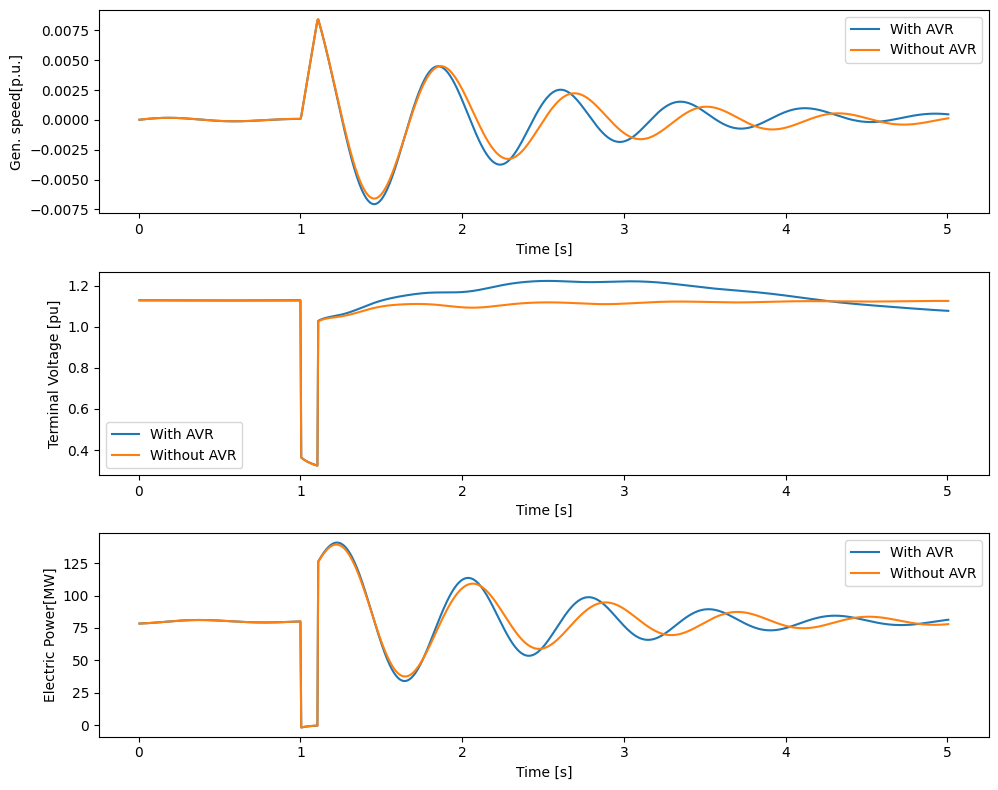

In [10]:
import sys
from collections import defaultdict
import time
# Solver and dynamic models
from tops import dynamic as dps
from tops import solvers as dps_sol

def simulate(simmodel, t_clear):
    # Power system model
    ps = dps.PowerSystemModel(model=simmodel)
    ps.init_dyn_sim()

    t_end = 5
    x_0 = ps.x_0.copy()
    # Solver
    sol = dps_sol.ModifiedEulerDAE(ps.state_derivatives, ps.solve_algebraic, 0, x_0, t_end, max_step=5e-3)

    # Initialize simulation
    t = 0
    t_0 = time.time()
    t_fault = 1
    #Three periods, small disturbance

    res = defaultdict(list)
    v_bus = []


    # Run simulation
    while t < t_end:
        sys.stdout.write("\r%d%%" % (t/(t_end)*100))

        # Apply fault
        if (t_fault<t<t_clear):
            ps.y_bus_red_mod[1,1] =1e6
        else:
            ps.y_bus_red_mod[ 1, 1] =0

        # Simulate next step
        result = sol.step()
        x = sol.y
        v = sol.v
        t = sol.t

        dx = ps.ode_fun(0, ps.x_0)

        # Store result
        v_bus.append(np.abs(v[0]))  # Stores magnitude of generator terminal voltage

        res['t'].append(t)
        res['gen_speed'].append(ps.gen['GEN'].speed(x, v).copy())
        res['power_angle'].append(ps.gen['GEN'].angle(x, v).copy())
        res['Electric Power'].append(ps.gen['GEN'].P_e(x, v).copy())

    print('Simulation completed in {:.2f} seconds.'.format(time.time() - t_0))

    return res, v_bus

res, v_bus = simulate(model_wAVR, t_clear)
res_NO_AVR, v_bus_NO_AVR = simulate(model_NO_AVR, t_clear)

fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plot generator speed
axs[0].plot(res['t'], np.transpose(res['gen_speed'])[0], label='With AVR')
axs[0].plot(res_NO_AVR['t'], np.transpose(res_NO_AVR['gen_speed'])[0], label='Without AVR')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Gen. speed[p.u.]')
axs[0].legend()


# Plot power angle
axs[1].plot(res['t'],v_bus, label='With AVR')
axs[1].plot(res_NO_AVR['t'],v_bus_NO_AVR, label='Without AVR')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Terminal Voltage [pu]')
axs[1].legend()

# Plot electric power
axs[2].plot(res['t'], np.transpose(res['Electric Power'])[0], label='With AVR')
axs[2].plot(res_NO_AVR['t'], np.transpose(res_NO_AVR['Electric Power'])[0], label='Without AVR')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Electric Power[MW]')

# Adjust layout
plt.legend()
plt.tight_layout()
plt.show()